[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb)

## Learning End-to-End Channel Coding with Diffusion Models
 
This notebook file is a framework to learn the E2E channel coding with a generated channel by using diffusion models. For diffusion models, we use two denoising algorithms, DDPM and DDIM. They are evaluated by the generative performance, sampling speed, and the E2E error probability of the channel codes trained with them. 
To train the E2E framework, we first train the channel generative model with Gaussian signals as channel input. And then, the encoder and decoder models are trained with a fake channel sampled by the generative model. 



In [1]:
# Set the path
GDRIVE_MOUNT = False # In case you use Google Colab with G-Drive
PLOT_FIGURES = True 

if GDRIVE_MOUNT: 
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    path = '/content/drive/MyDrive/Colab Notebooks' # The path to the source codes
else: 
    path = !pwd
    path = path[0] # The path with the lbraries

import sys
sys.path.append(path+'/src')

# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.nn import functional as F
import pickle
import csv
from tqdm import tqdm
from utils import *
from utils_plot import *
import trainer as trainer

# Import modules from own libraries
import models
from channel_models import *
from ema import EMA

# Set the device 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Choose channel model and diffusion model type

In [2]:
channel_model_str = 'SSPA' #available options: AWGN, Rayleigh, SSPA
denoising_alg = 'DDPM' #available options: DDPM, DDIM


## Channel model settings

In [3]:
# Channel Model
M = 64
k = math.log2(M)
n = 8  # Block length
rate = k/n 


if channel_model_str == 'AWGN':
    channel_model = ch_AWGN
elif channel_model_str == 'Rayleigh':
    channel_model = ch_Rayleigh_AWGN
elif channel_model_str == 'SSPA':
    channel_model = ch_SSPA
else:
    raise Exception("Unrecognized channel model. Possible channel models: AWGN, Rayleigh, SSPA.")


## Deep Learning Settings - model parameters, training and testing hyperparameters, etc.

In [4]:
# Load and save models before and after training, respectively. 
LOADMODEL_gen = False
LOADMODEL_AE = False

SAVEMODEL_gen = False 
SAVEMODEL_AE = False

# Framework 
TRAINING_EbN0 = 9 # decibel
noise_std = EbNo_to_noise(TRAINING_EbN0, rate)

# Autoencoder (AE) Model (channel coding encoder & decoder)
### Models 
encoder = models.Encoder_1h(M, n, n/2).to(device)# _1h means taking one hot encoded messages. _n means normalizing the output.
decoder = models.Decoder_1h(M, n).to(device)
optimizer_AE = torch.optim.NAdam

# Diffusion Model
### Model Parameters
N_hl = 110 # Number of neurons in the hidden layer
num_steps = 100 # T
skip = 1 # Set this as 1 if DDPM. If DDIM, choose between 1 to T.
if denoising_alg == 'DDPM': 
    traj = range(0,num_steps)
elif denoising_alg == 'DDIM':
    traj = range(skip-1, num_steps, skip)

### Noise scheduling    
scheduling = 'cosine' # options: 'cosine', 'const', 'sigmoid'

if scheduling == 'cosine':
    betas = make_beta_schedule(schedule='cosine-zf', n_timesteps=num_steps).to(device) # cosine scheduling
elif scheduling == 'const': 
    betas = torch.tensor([5e-2] * num_steps).to(device) # constant beta, no scheduling. 
elif scheduling == 'sigmoid':
    betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-3, end=5e-2).to(device) # sigmoid scheduling
else:
    assert False, "Undefined scheduling method."

pred_type = 'v' # Available options: 'epsilon', v.

channel_gen = models.ConditionalModel_w_Condition(num_steps, 0, n, N_hl).to(device) # The condition includes the channel input.
optimizer_gen = optim.Adam
ema = EMA(0.9) # Create EMA model (Exponential Moving Average)
ema.register(channel_gen)

# Test Setting
ebn0_range = [*range(1,11+1)]
dataset_size_test = 1000000
batch_size_test = 100
max_epoch_test = 30


# File tag for saving and loading
file_tag = f'_{channel_model_str}_M{M}N{n}_{scheduling}'

model_tag_load_gen = file_tag +'.pt' 
model_tag_load_AE = file_tag +'.pt'
model_tag_save_gen = file_tag +'.pt'
model_tag_save_AE = file_tag +'.pt' 

path_state_dict = path + '/state_dict'

In [5]:
total_params_gen = sum(p.numel() for p in channel_gen.parameters() if p.requires_grad)
print('# of parameters (diffusion model): ' + str(total_params_gen))
total_params_enc = sum(p.numel() for p in encoder.parameters())
print('# of parameters (encoder): ' + str(total_params_enc))
total_params_dec = sum(p.numel() for p in decoder.parameters())
print('# of parameters (decoder): ' + str(total_params_dec))


# of parameters (diffusion model): 60178
# of parameters (encoder): 8840
# of parameters (decoder): 8896


## Defining variables and functions for diffusion models

In [6]:
# Calculating constants

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
#alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float().to(device), alphas_prod[:-1]], 0)
 
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [7]:
def q_x(x_0, t, noise=None):
    shape = x_0.shape
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, shape)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, shape)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [8]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    shape = x_0.shape
    coef_1 = extract(posterior_mean_coef_1, t, shape)
    coef_2 = extract(posterior_mean_coef_2, t, shape)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, shape)
    return mean, var

Diffusion process for message 1 in the first two dimensions.


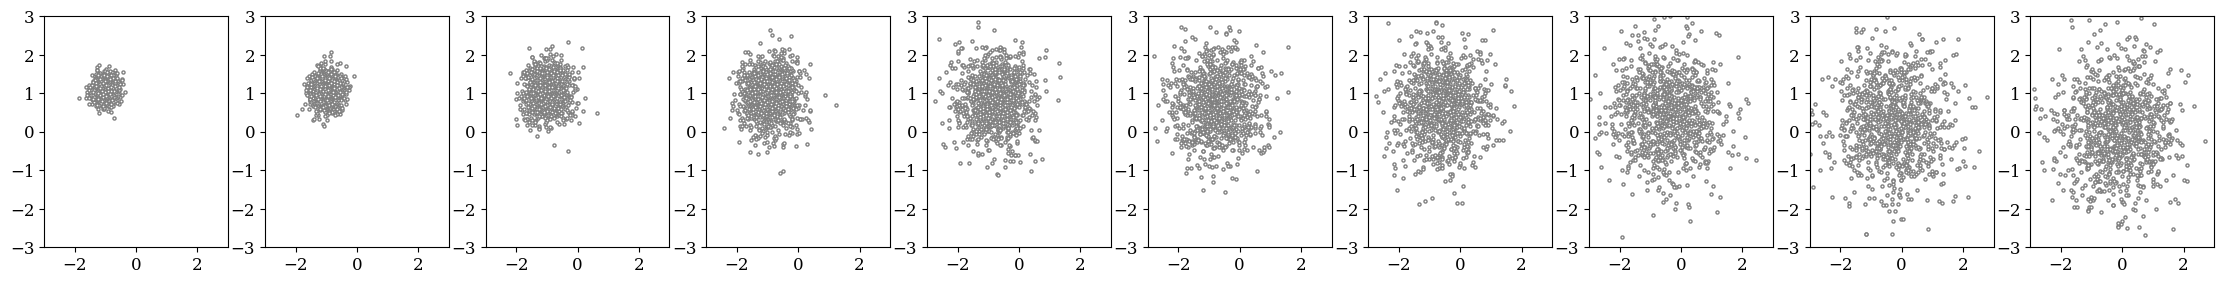

Adjust beta according to the diffusion results. If it needs to be more noisy, increase beta. If it gets noisy too soon, decrease beta.


In [9]:
# Checking diffusion process 

if PLOT_FIGURES:
    show_diffusion_m(channel_model, q_x, encoder, device, noise_std, M=M, m = 0,num_samples_df=1000
                     ,num_steps=num_steps, max_amp = 3)
 

# Training E2E framework

In [10]:
# Load pretrained diffusion model if necessary

load_class = LoadModels(path_state_dict, LOADMODEL_gen, channel_gen, model_tag_load_gen, LOADMODEL_AE, encoder
                        , decoder, model_tag_load_AE)

channel_gen, encoder, decoder = load_class.load() # It loads only the models whose LOADMODEL flag is True.


epoch 5: loss 2.04e-01: 100%|███████████████| 2442/2442 [00:45<00:00, 53.90it/s]


The denoising process is plotted for the message 1 and the first two dimensions.


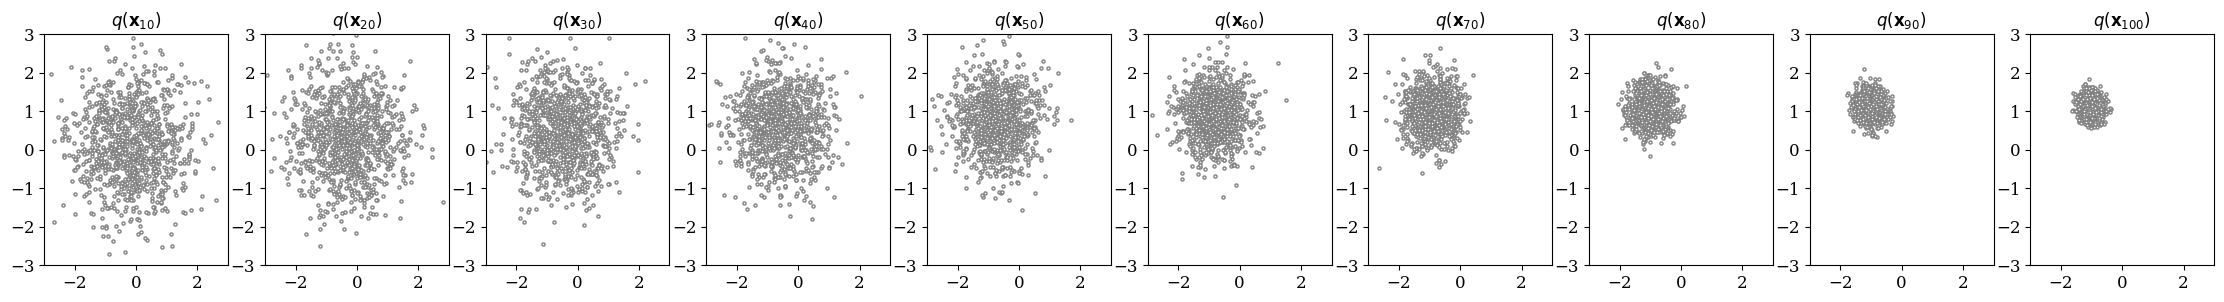

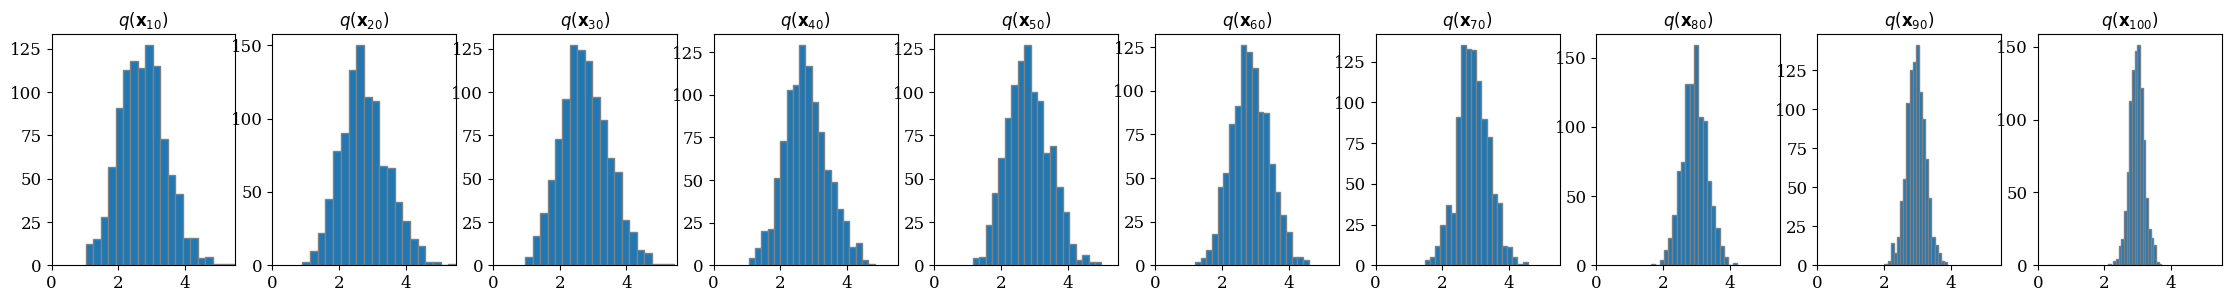

Training the generative model is completed.


In [13]:
# Training Phase 1: Learn the channel by training the diffusion model. 
# Freeze enc/dec pair and optimize the diffusion model.

## Training dataset: Gaussian channel input and channel output. 

dataset_size_gen = 10**7 
batch_size_gen = 4096
max_epoch_gen = 5 
lr_gen = 1e-3

tconf_gen = trainer.TrainerConfig_DDM(max_epochs = max_epoch_gen, dataset_size = dataset_size_gen
                                      , batch_size = batch_size_gen, noise_std = noise_std
                                      , learning_rate = lr_gen, M = M, n = n, rate = rate
                                      , num_steps = num_steps, betas = betas, optim_gen = optimizer_gen
                                      , pred_type = pred_type)

t_gen = trainer.Trainer_DDM(channel_gen, ema, device, channel_model, tconf_gen)
t_gen.train_PreT()


if PLOT_FIGURES :   
    show_denoising_m(channel_gen, encoder, device, alphas, betas, alphas_bar_sqrt, one_minus_alphas_bar_sqrt,
                     M =M, m = 0, num_samples_dn = 1000, num_steps = num_steps,max_amp=3,
                     PreT=True, denoising_alg = denoising_alg, traj = traj, pred_type=pred_type) 

print('Training the generative model is completed.')   




In [ ]:
# Save the diffusion model if necessary
model_tag_load_gen = file_tag +'.pt' 
model_tag_load_AE = file_tag +'.pt' 
model_tag_save_gen = file_tag +'.pt'
model_tag_save_AE = file_tag +'.pt' 

path_state_dict = path + '/state_dict'

SAVEMODEL_gen = True
SAVEMODEL_AE = False
save_class = SaveModels(path_state_dict, SAVEMODEL_gen, channel_gen, model_tag_save_gen, SAVEMODEL_AE, encoder
                        , decoder, model_tag_save_AE)
save_class.model_gen = channel_gen
save_class.save_gen()

# Check the diffusion models by figures

The evaluation of generated channel in comparison to the original source; m = 2


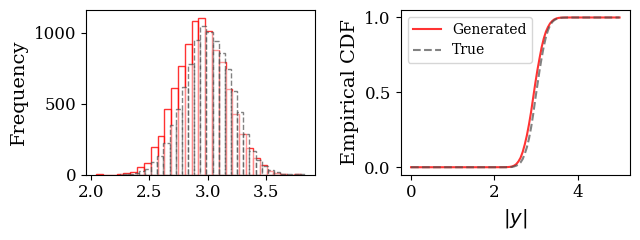

In [14]:
#denoising_alg = 'DDPM'
#skip = 1
#traj = range(skip-1, num_steps, skip)

if PLOT_FIGURES:
    ECDF_histogram_m(encoder, channel_gen, channel_model_str, device, alphas, betas, alphas_bar_sqrt
                     , one_minus_alphas_bar_sqrt
                     , num_steps, M, 10000,1000, noise_std,max_amp=5, m=1, PreT=True
                     , denoising_alg = denoising_alg, traj = traj, pred_type=pred_type)


The scatter plot of the generated data in comparison to the original source; message 1


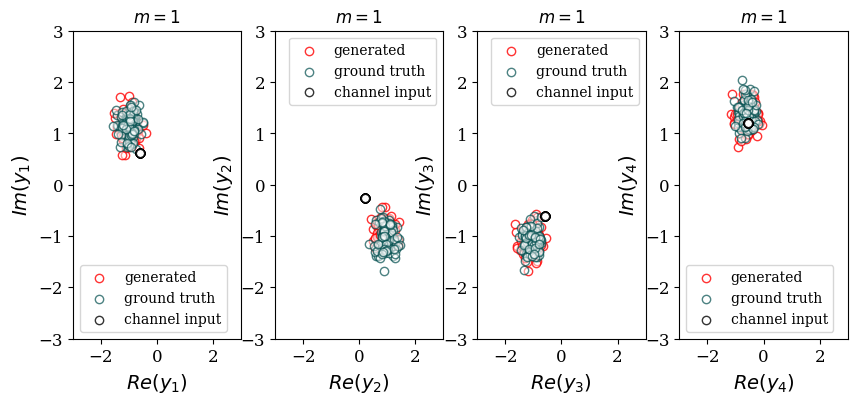

In [15]:
#denoising_alg = 'DDIM' 
#skip = 1 
#traj = range(skip-1, num_steps, skip) # starting from 0 ending with (num_steps-1)

if PLOT_FIGURES:
    Constellation_InOut_m(encoder, channel_gen, channel_model_str, device, alphas, betas, alphas_bar_sqrt
                          , one_minus_alphas_bar_sqrt
                          , num_steps, M, 100, noise_std, m=0, max_amp=3, PreT=True
                          , denoising_alg = denoising_alg
                          , traj = traj, pred_type=pred_type)


The denoising process is plotted for the message 1 and the first two dimensions.


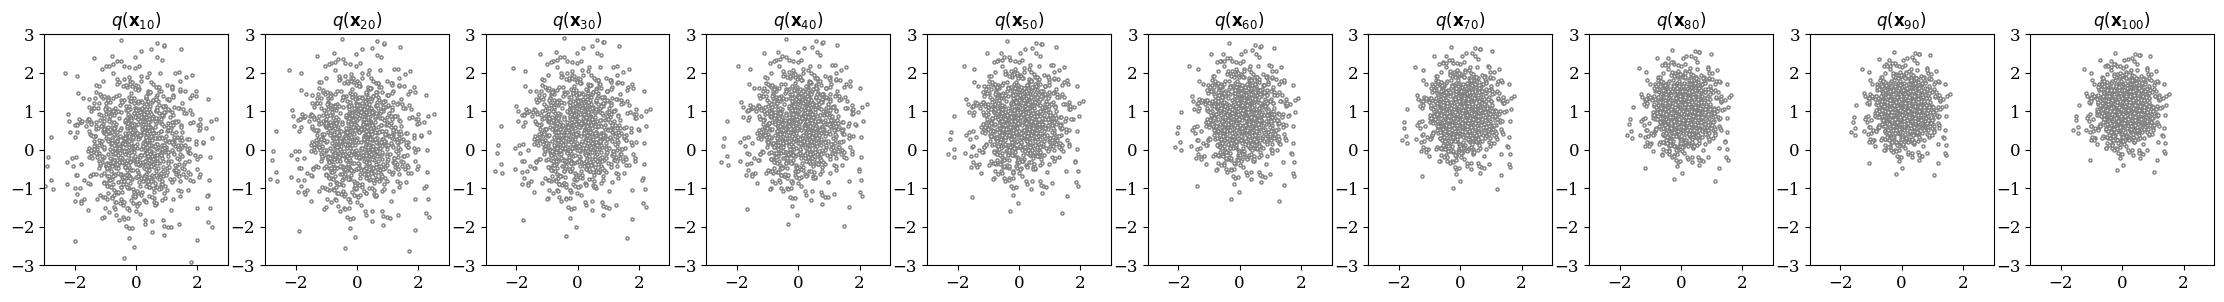

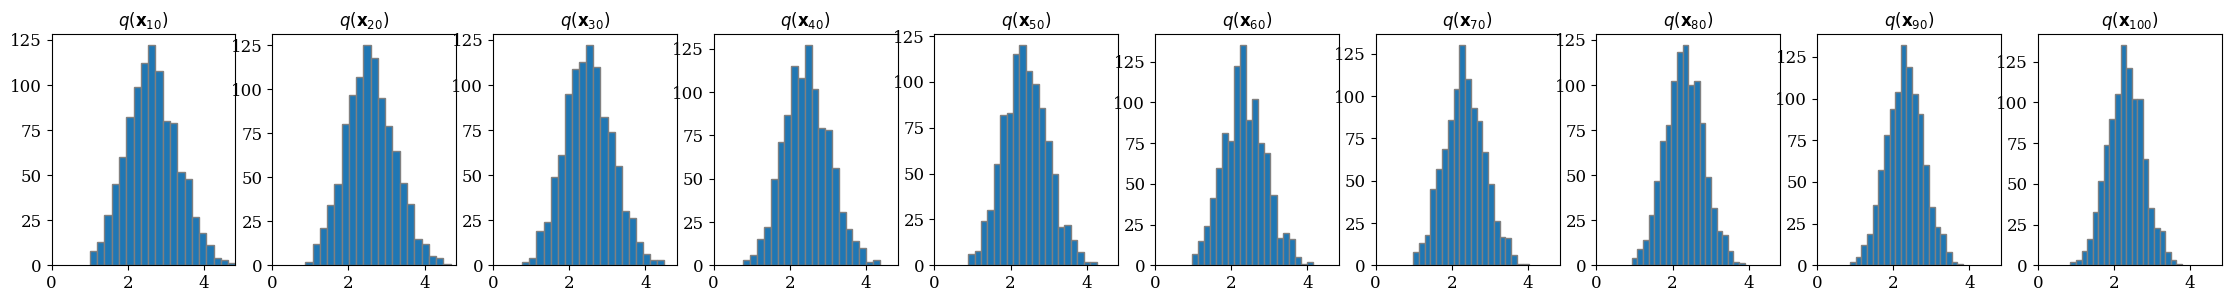

In [54]:
show_denoising_m(channel_gen, encoder, device, alphas, betas, alphas_bar_sqrt
                 , one_minus_alphas_bar_sqrt, M = M
                 , m = 0, num_samples_dn = 1000, num_steps = num_steps,max_amp=3, PreT=True
                 , denoising_alg = denoising_alg, traj = traj, pred_type=pred_type) 


# Train AEs with different sampling algorithms

In [16]:
# Training Phase 2: train the AE with generated channel outputs. 
# Freeze the diffusion model and optimize the AE.

## Training dataset: uniformly distributed messages, encoded codewords, channel outputs of those codewords.

SER_val = []
loss_AE = []

SAVEMODEL_gen = False
SAVEMODEL_AE = True

lr_AE = 1e-3 # learning rate of the encoder/decoder.
dataset_size_AE = 1000000
batch_size_AE = 100
max_epoch_AE = 10

denoising_alg = 'DDIM'
skip = 20
traj = range(skip-1, num_steps, skip)

encoder = models.Encoder_1h(M, n, n).to(device) # _1h means taking one hot encoded messages.
decoder = models.Decoder_1h(M, n).to(device)

dataset_AE = np.random.randint(M, size=dataset_size_AE)
tconf_AE = trainer.TrainerConfig_AE_w_DDM(max_epochs = max_epoch_AE, dataset_size = dataset_size_AE
                                          , batch_size = batch_size_AE, noise_std = noise_std
                                          , learning_rate = lr_AE, M = M, n=n, rate = rate
                                          , num_steps = num_steps, traj = traj, denoising_alg = denoising_alg
                                          , optim_AE = optimizer_AE, betas=betas, channel_model = channel_model
                                          , pred_type = pred_type)
t_AE = trainer.Trainer_AE_w_DDM(encoder, decoder, channel_gen, device, tconf_AE)
t_AE.train_PreT()
print('Training the AE model is completed.')

t_AE.test(channel_model)

if denoising_alg == 'DDPM:
    file_tag_tmp = file_tag + '_' + denoising_alg
elif denoising_alg == 'DDIM':
    file_tag_tmp = file_tag + '_' + denoising_alg + str(skip)
model_tag_save_AE = file_tag_tmp +'.pt' 

save_class = SaveModels(path_state_dict, SAVEMODEL_gen, channel_gen, model_tag_save_gen, SAVEMODEL_AE, encoder
                        , decoder, model_tag_save_AE)
save_class.save_AE()



epoch 1: loss 3.84e-02 SER 5.55e-03: 100%|█| 10000/10000 [10:28<00:00, 15.91it/s
epoch 2: loss 1.97e-03 SER 1.60e-04: 100%|█| 10000/10000 [10:14<00:00, 16.28it/s
epoch 3: loss 1.65e-07 SER 0.00e+00: 100%|█| 10000/10000 [08:35<00:00, 19.40it/s
epoch 4: loss 4.30e-05 SER 1.51e-05: 100%|█| 10000/10000 [07:09<00:00, 23.28it/s
epoch 5: loss 1.57e-08 SER 0.00e+00: 100%|█| 10000/10000 [06:56<00:00, 24.01it/s
epoch 6: loss 4.66e-05 SER 1.41e-05: 100%|█| 10000/10000 [06:56<00:00, 24.02it/s
epoch 7: loss 7.89e-05 SER 1.41e-05: 100%|█| 10000/10000 [06:54<00:00, 24.14it/s
epoch 8: loss 3.64e-08 SER 0.00e+00: 100%|█| 10000/10000 [06:35<00:00, 25.25it/s
epoch 9: loss 5.20e-10 SER 0.00e+00: 100%|█| 10000/10000 [04:47<00:00, 34.83it/s
epoch 10: loss 1.44e-04 SER 2.63e-05: 100%|█| 10000/10000 [04:28<00:00, 37.23it/


Training the AE model is completed.


Validation SER 1.28e-04: 100%|██████████| 10000/10000 [00:09<00:00, 1033.69it/s]


# Test AEs of different sampling algorithms


In [19]:
# Test the AE

labels = torch.randint(low=0, high=M, size=[dataset_size_test])
tconf = trainer.TrainerConfig(max_epochs=max_epoch_test, noise_std = noise_std, batch_size=batch_size_test
                              , M=M, rate=rate, pred_type=pred_type)

#Load the encoder and decoder if necessary
#file_tag_tmp = file_tag + denoising_alg + str(skip)
#model_tag_load_AE = file_tag_tmp +'.pt'
#LOADMODEL_AE = True
#load_class = LoadModels(path_state_dict, SAVEMODEL_gen, channel_gen
#                        , model_tag_save_gen, SAVEMODEL_AE, encoder
#                        , decoder, model_tag_save_AE)
#_, encoder, decoder = load_class.load() # It loads only the models whose LOADMODEL flag is True.


if channel_model_str == 'AWGN':
    channel_diff_test = models.Channel(encoder, decoder).to(device)
if channel_model_str == 'Rayleigh':
    channel_diff_test = models.Channel_ray_n(encoder, decoder).to(device)
if channel_model_str == 'SSPA':
    channel_diff_test = models.Channel_SSPA(encoder, decoder).to(device)
    
t_diff = trainer.Trainer(channel_diff_test, labels, tconf, one_hot=True)
SER = t_diff.test(snr_range=ebn0_range, one_hot=True, erasure_bound=0.7) 
        

SNR 9  iter 9900: SER 1.333e-04: 100%|███| 10000/10000 [00:13<00:00, 719.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 9  iter 9900: SER 1.303e-04: 100%|███| 10000/10000 [00:15<00:00, 654.35it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 9  iter 9900: SER 1.273e-04: 100%|███| 10000/10000 [00:15<00:00, 657.51it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 9  iter 9900: SER 1.222e-04: 100%|███| 10000/10000 [00:15<00:00, 657.81it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 9  iter 9900: SER 1.424e-04: 100%|███| 10000/10000 [00:14<00:00, 666.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 9  iter 9900: SER 1.232e-04: 100%|███| 10000/10000 [00:14<00:00, 675.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 10  iter 9900: SER 3.535e-05: 100%|██| 10000/10000 [00:14<00:00, 703.04it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 10  iter 9900: SER 2.727e-05: 100%|██| 10000/10000 [00:14<00:00, 708.14it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 10  iter 9900: SER 2.727e-05: 100%|██| 10000/10000 [00:14<00:00, 699.06it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 10  iter 9900: SER 3.131e-05: 100%|██| 10000/10000 [00:14<00:00, 700.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 10  iter 9900: SER 3.131e-05: 100%|██| 10000/10000 [00:14<00:00, 699.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 10  iter 9900: SER 3.838e-05: 100%|██| 10000/10000 [00:14<00:00, 696.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 10  iter 9900: SER 2.929e-05: 100%|██| 10000/10000 [00:12<00:00, 781.47it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 10  iter 9900: SER 2.020e-05: 100%|██| 10000/10000 [00:12<00:00, 809.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 10  iter 9900: SER 2.626e-05: 100%|██| 10000/10000 [00:12<00:00, 796.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 10  iter 9900: SER 2.727e-05: 100%|██| 10000/10000 [00:12<00:00, 816.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 10  iter 9900: SER 2.727e-05: 100%|██| 10000/10000 [00:12<00:00, 806.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 10  iter 9900: SER 2.626e-05: 100%|██| 10000/10000 [00:12<00:00, 806.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 10  iter 9900: SER 3.232e-05: 100%|██| 10000/10000 [00:12<00:00, 813.65it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 10  iter 9900: SER 2.626e-05: 100%|██| 10000/10000 [00:12<00:00, 802.87it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 10  iter 9900: SER 2.222e-05: 100%|██| 10000/10000 [00:12<00:00, 813.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 10  iter 9900: SER 1.919e-05: 100%|██| 10000/10000 [00:12<00:00, 816.00it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 10  iter 9900: SER 4.040e-05: 100%|██| 10000/10000 [00:12<00:00, 810.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  18000000


SNR 10  iter 9900: SER 2.525e-05: 100%|██| 10000/10000 [00:12<00:00, 802.34it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  19000000


SNR 10  iter 9900: SER 3.434e-05: 100%|██| 10000/10000 [00:12<00:00, 818.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 10  iter 9900: SER 2.525e-05: 100%|██| 10000/10000 [00:12<00:00, 812.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  21000000


SNR 10  iter 9900: SER 3.030e-05: 100%|██| 10000/10000 [00:12<00:00, 816.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  22000000


SNR 10  iter 9900: SER 2.121e-05: 100%|██| 10000/10000 [00:12<00:00, 819.77it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  23000000


SNR 10  iter 9900: SER 1.717e-05: 100%|██| 10000/10000 [00:12<00:00, 816.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  24000000


SNR 10  iter 9900: SER 2.222e-05: 100%|██| 10000/10000 [00:12<00:00, 825.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  25000000


SNR 10  iter 9900: SER 2.929e-05: 100%|██| 10000/10000 [00:12<00:00, 813.50it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  26000000


SNR 10  iter 9900: SER 3.838e-05: 100%|██| 10000/10000 [00:12<00:00, 815.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  27000000


SNR 10  iter 9900: SER 2.929e-05: 100%|██| 10000/10000 [00:12<00:00, 815.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  28000000


SNR 10  iter 9900: SER 2.525e-05: 100%|██| 10000/10000 [00:12<00:00, 814.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  29000000


SNR 10  iter 9900: SER 3.131e-05: 100%|██| 10000/10000 [00:12<00:00, 818.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 10  iter 9900: SER 3.131e-05: 100%|██| 10000/10000 [00:12<00:00, 830.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  31000000


SNR 10  iter 9900: SER 3.030e-05: 100%|██| 10000/10000 [00:12<00:00, 809.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  32000000


SNR 10  iter 9900: SER 2.424e-05: 100%|██| 10000/10000 [00:12<00:00, 819.41it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  33000000


SNR 10  iter 9900: SER 2.727e-05: 100%|██| 10000/10000 [00:12<00:00, 826.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  34000000


SNR 10  iter 9900: SER 2.727e-05: 100%|██| 10000/10000 [00:12<00:00, 815.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  35000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 818.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 824.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 814.06it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 817.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:12<00:00, 822.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 11  iter 9900: SER 0.000e+00: 100%|██| 10000/10000 [00:12<00:00, 809.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 829.04it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:12<00:00, 813.33it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 812.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 824.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:12<00:00, 815.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 829.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:12<00:00, 816.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 808.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 828.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 816.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 817.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  18000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 821.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  19000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:12<00:00, 816.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 819.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  21000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 820.61it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  22000000


SNR 11  iter 9900: SER 1.010e-05: 100%|██| 10000/10000 [00:12<00:00, 806.41it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  23000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 806.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  24000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 812.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  25000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:12<00:00, 802.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  26000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 809.87it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  27000000


SNR 11  iter 9900: SER 0.000e+00: 100%|██| 10000/10000 [00:12<00:00, 809.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  28000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 808.97it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  29000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 813.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 11  iter 9900: SER 1.010e-05: 100%|██| 10000/10000 [00:12<00:00, 813.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  31000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:12<00:00, 806.77it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  32000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 814.27it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  33000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 811.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  34000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 810.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  35000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 816.50it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  36000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 804.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  37000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:12<00:00, 814.33it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  38000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 817.47it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  39000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 799.51it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 816.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  41000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 811.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  42000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 801.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  43000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:12<00:00, 804.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  44000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:12<00:00, 807.22it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  45000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 806.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  46000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:12<00:00, 808.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  47000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:12<00:00, 804.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  48000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 811.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  49000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 820.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 801.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  51000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 815.00it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  52000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 810.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  53000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:12<00:00, 803.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  54000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 804.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  55000000


SNR 11  iter 9900: SER 0.000e+00: 100%|██| 10000/10000 [00:12<00:00, 801.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  56000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 808.85it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  57000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:12<00:00, 811.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  58000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 806.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  59000000


SNR 11  iter 9900: SER 9.090e-06: 100%|██| 10000/10000 [00:12<00:00, 815.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 814.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  61000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 808.36it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  62000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 810.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  63000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 815.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  64000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:12<00:00, 806.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  65000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 811.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  66000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:12<00:00, 803.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  67000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 812.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  68000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 807.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  69000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 798.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 818.76it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  71000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 812.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  72000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 807.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  73000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 817.35it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  74000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 822.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  75000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 803.06it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  76000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 810.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  77000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 796.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  78000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 808.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  79000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:12<00:00, 810.48it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:12<00:00, 808.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  81000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:12<00:00, 809.96it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  82000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:12<00:00, 815.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  83000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:12<00:00, 806.88it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  84000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 807.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  85000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:12<00:00, 827.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  86000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:11<00:00, 898.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  87000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:11<00:00, 907.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  88000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:12<00:00, 813.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  89000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:14<00:00, 710.87it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 717.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  91000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 707.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  92000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 719.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  93000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 716.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  94000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 719.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  95000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 728.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  96000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:14<00:00, 709.36it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  97000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 671.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  98000000


SNR 11  iter 9900: SER 1.111e-05: 100%|██| 10000/10000 [00:14<00:00, 669.49it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  99000000


SNR 11  iter 9900: SER 0.000e+00: 100%|██| 10000/10000 [00:14<00:00, 689.33it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:14<00:00, 693.27it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  101000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 690.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  102000000


SNR 11  iter 9900: SER 8.080e-06: 100%|██| 10000/10000 [00:14<00:00, 689.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  103000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 688.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  104000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:14<00:00, 696.61it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  105000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 694.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  106000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:14<00:00, 687.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  107000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 695.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  108000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:14<00:00, 691.42it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  109000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 689.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 687.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  111000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:14<00:00, 694.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  112000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 698.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  113000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 691.97it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  114000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 685.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  115000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 729.51it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  116000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 741.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  117000000


SNR 11  iter 9900: SER 8.080e-06: 100%|██| 10000/10000 [00:13<00:00, 747.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  118000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 750.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  119000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 740.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 731.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  121000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 748.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  122000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 745.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  123000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 751.09it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  124000000


SNR 11  iter 9900: SER 9.090e-06: 100%|██| 10000/10000 [00:13<00:00, 753.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  125000000


SNR 11  iter 9900: SER 1.111e-05: 100%|██| 10000/10000 [00:13<00:00, 738.50it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  126000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 751.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  127000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 751.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  128000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 739.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  129000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 750.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  130000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 741.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  131000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 747.96it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  132000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 749.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  133000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 754.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  134000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 729.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  135000000


SNR 11  iter 9900: SER 8.080e-06: 100%|██| 10000/10000 [00:14<00:00, 711.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  136000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 733.33it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  137000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 724.93it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  138000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:14<00:00, 712.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  139000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:15<00:00, 657.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  140000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 693.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  141000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 690.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  142000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:14<00:00, 694.33it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  143000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:14<00:00, 686.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  144000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:14<00:00, 692.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  145000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 679.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  146000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 691.31it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  147000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:14<00:00, 690.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  148000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:14<00:00, 696.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  149000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 694.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  150000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:14<00:00, 692.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  151000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:14<00:00, 685.90it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  152000000


SNR 11  iter 9900: SER 8.080e-06: 100%|██| 10000/10000 [00:14<00:00, 691.35it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  153000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 697.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  154000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:14<00:00, 696.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  155000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:14<00:00, 689.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  156000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:14<00:00, 688.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  157000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:14<00:00, 688.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  158000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 728.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  159000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 744.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  160000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 743.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  161000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 725.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  162000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 747.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  163000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 739.34it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  164000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 733.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  165000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 743.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  166000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 750.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  167000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 743.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  168000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 742.81it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  169000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 745.34it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  170000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 734.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  171000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 739.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  172000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 751.48it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  173000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 744.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  174000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 745.90it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  175000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 745.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  176000000


SNR 11  iter 9900: SER 0.000e+00: 100%|██| 10000/10000 [00:13<00:00, 748.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  177000000


SNR 11  iter 9900: SER 8.080e-06: 100%|██| 10000/10000 [00:13<00:00, 745.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  178000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 757.45it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  179000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 751.00it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  180000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 742.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  181000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 755.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  182000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 744.52it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  183000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 749.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  184000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 747.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  185000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 751.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  186000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 749.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  187000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 748.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  188000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 745.51it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  189000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 740.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  190000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 744.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  191000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 754.47it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  192000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 751.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  193000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 743.33it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  194000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 750.31it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  195000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 755.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  196000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 746.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  197000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 752.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  198000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 745.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  199000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 749.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  200000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 746.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  201000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 753.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  202000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 751.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  203000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 752.14it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  204000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 748.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  205000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 747.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  206000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 751.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  207000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 755.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  208000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 739.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  209000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 737.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  210000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 755.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  211000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 752.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  212000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 746.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  213000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 748.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  214000000


SNR 11  iter 9900: SER 9.090e-06: 100%|██| 10000/10000 [00:13<00:00, 745.65it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  215000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 746.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  216000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 740.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  217000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 746.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  218000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 740.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  219000000


SNR 11  iter 9900: SER 6.060e-06: 100%|██| 10000/10000 [00:13<00:00, 747.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  220000000


SNR 11  iter 9900: SER 8.080e-06: 100%|██| 10000/10000 [00:13<00:00, 750.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  221000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 746.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  222000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 742.27it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  223000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 756.50it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  224000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 740.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  225000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 735.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  226000000


SNR 11  iter 9900: SER 8.080e-06: 100%|██| 10000/10000 [00:13<00:00, 741.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  227000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 745.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  228000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 748.45it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  229000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 742.36it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  230000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 746.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  231000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 741.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  232000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 755.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  233000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 754.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  234000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 745.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  235000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 747.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  236000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 750.79it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  237000000


SNR 11  iter 9900: SER 7.070e-06: 100%|██| 10000/10000 [00:13<00:00, 748.34it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  238000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 753.64it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  239000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 739.09it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  240000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 744.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  241000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 749.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  242000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 756.48it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  243000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 744.06it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  244000000


SNR 11  iter 9900: SER 9.090e-06: 100%|██| 10000/10000 [00:13<00:00, 747.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  245000000


SNR 11  iter 9900: SER 5.050e-06: 100%|██| 10000/10000 [00:13<00:00, 755.72it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  246000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 740.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  247000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 748.90it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  248000000


SNR 11  iter 9900: SER 3.030e-06: 100%|██| 10000/10000 [00:13<00:00, 747.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  249000000


SNR 11  iter 9900: SER 4.040e-06: 100%|██| 10000/10000 [00:13<00:00, 751.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  250000000


SNR 11  iter 9900: SER 2.020e-06: 100%|██| 10000/10000 [00:13<00:00, 736.27it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  251000000


SNR 11  iter 9900: SER 1.010e-06: 100%|██| 10000/10000 [00:13<00:00, 757.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  252000000


SNR 11  iter 9900: SER 0.000e+00: 100%|██| 10000/10000 [00:13<00:00, 750.61it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  253000000


SNR 11  iter 9900: SER 1.010e-05: 100%|██| 10000/10000 [00:13<00:00, 743.21it/s]


# Plot figures 

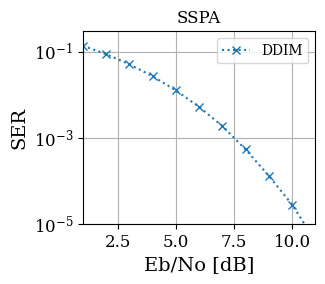

In [24]:
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid', 'dotted', 'dashed', 'dashdot']

if PLOT_FIGURES:
    fig = plt.figure(figsize=(3, 2.5))
    # Plot Autoencoder
    plt.semilogy(ebn0_range, SER, 'x:', label = denoising_alg)
    plt.gca().set_ylim(1e-5, 3e-1)
    plt.gca().set_xlim(ebn0_range[0], ebn0_range[-1])
    plt.ylabel("SER", rotation=90)
    plt.xlabel("Eb/No [dB]")
    plt.title(channel_model_str)
    plt.legend()

    plt.grid(True, which="both")
    plt.savefig('figures/EbN0_vs._testSER_sample_'+channel_model_str+'.pdf', bbox_inches='tight')
    plt.show()


The scatter plot of the generated data in comparison to the original source; message 5


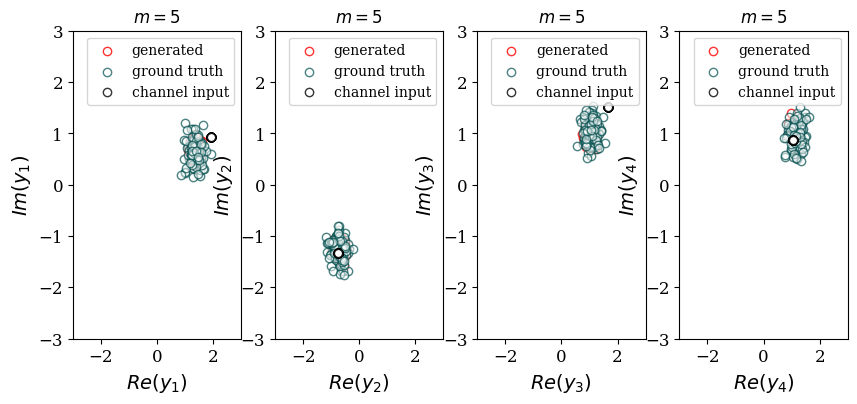

In [21]:
if PLOT_FIGURES:            
    Constellation_InOut_m(encoder, channel_gen, channel_model_str, device, alphas, betas, alphas_bar_sqrt
                            , one_minus_alphas_bar_sqrt, num_steps, M, 100, noise_std, 3, m=4, PreT=True
                            , denoising_alg = denoising_alg, traj = traj, pred_type = pred_type)

Constellation of learned encoder


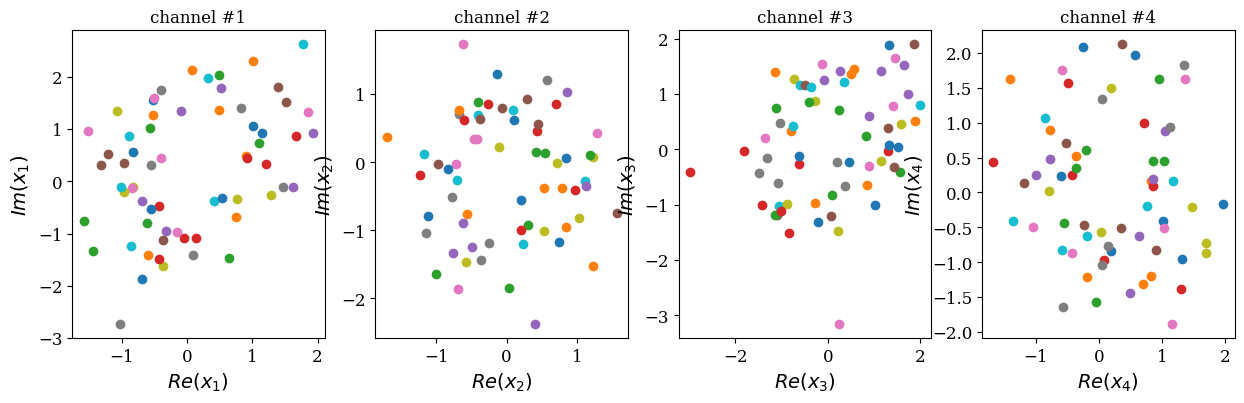

In [22]:
if PLOT_FIGURES:
    Constellation_Enc(encoder, M)